# Using a Temporal Convolutional Network for Daytrading
## Daniel Kalam, Sharvita Paithankar

In [513]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv1D, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
from pandas_datareader import DataReader
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

## Gathering Data
Getting data for 100 stocks in the date range of April 2nd, 2018 to October 9th, 2020 from yahoo finance.

In [514]:
symbol = 'SPY'
source = 'yahoo'
start_date = pd.to_datetime('2012-10-09')
end_date = pd.to_datetime('2020-10-09')

df = DataReader(symbol, source, start_date, end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-10-09,145.649994,144.149994,145.529999,144.199997,148872900.0,122.982086
2012-10-10,144.320007,143.089996,144.179993,143.279999,124247500.0,122.197456
2012-10-11,144.490005,143.330002,144.279999,143.360001,123601500.0,122.265709
2012-10-12,143.949997,142.580002,143.460007,142.889999,124181900.0,121.864883
2012-10-15,144.229996,142.770004,143.229996,144.080002,107689100.0,122.879723
...,...,...,...,...,...,...
2020-10-05,339.959991,336.010010,336.059998,339.760010,45713100.0,339.760010
2020-10-06,342.170013,334.380005,339.910004,334.929993,90128900.0,334.929993
2020-10-07,341.630005,338.089996,338.119995,340.760010,56999600.0,340.760010


Create a data frame for each column in a stock's data frame.

In [515]:
# 1 = upwared movement 0 = downward or stagnient
df['Buy'] = df['Open'] < df['Close']
df['Buy'] = df['Buy'].astype(int)
df

,High,Low,Open,Close,Volume,Adj Close,Buy
Date,,,,,,,
2012-10-09,145.649994,144.149994,145.529999,144.199997,148872900.0,122.982086,0
2012-10-10,144.320007,143.089996,144.179993,143.279999,124247500.0,122.197456,0
2012-10-11,144.490005,143.330002,144.279999,143.360001,123601500.0,122.265709,0
2012-10-12,143.949997,142.580002,143.460007,142.889999,124181900.0,121.864883,0
2012-10-15,144.229996,142.770004,143.229996,144.080002,107689100.0,122.879723,1
...,...,...,...,...,...,...,...
2020-10-05,339.959991,336.010010,336.059998,339.760010,45713100.0,339.760010,1
2020-10-06,342.170013,334.380005,339.910004,334.929993,90128900.0,334.929993,0
2020-10-07,341.630005,338.089996,338.119995,340.760010,56999600.0,340.760010,1


In [516]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
High,2014.0,2.331678e+02,5.122239e+01,1.364900e+02,1.965250e+02,2.176900e+02,2.770275e+02,3.587500e+02
Low,2014.0,2.307691e+02,5.051635e+01,1.347000e+02,1.945000e+02,2.162200e+02,2.740775e+02,3.534300e+02
Open,2014.0,2.320219e+02,5.089854e+01,1.359000e+02,1.954550e+02,2.171150e+02,2.757675e+02,3.558700e+02
Close,2014.0,2.320565e+02,5.088075e+01,1.357000e+02,1.956275e+02,2.172100e+02,2.750100e+02,3.577000e+02
Volume,2014.0,1.017212e+08,5.142908e+07,2.027000e+07,6.614118e+07,8.940720e+07,1.225312e+08,5.072443e+08
Adj Close,2014.0,2.167236e+02,5.693693e+01,1.157328e+02,1.747039e+02,2.004483e+02,2.643780e+02,3.562739e+02
Buy,2014.0,5.461768e-01,4.979868e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [517]:
df.corr()['Close'].sort_values()

Volume      -0.356794
Buy          0.000973
Adj Close    0.998807
Open         0.999335
High         0.999489
Low          0.999561
Close        1.000000
Name: Close, dtype: float64

In [518]:
df.corr()['Buy'].sort_values()

Volume      -0.112950
Open        -0.022040
High        -0.012820
Low         -0.009744
Adj Close    0.000451
Close        0.000973
Buy          1.000000
Name: Buy, dtype: float64

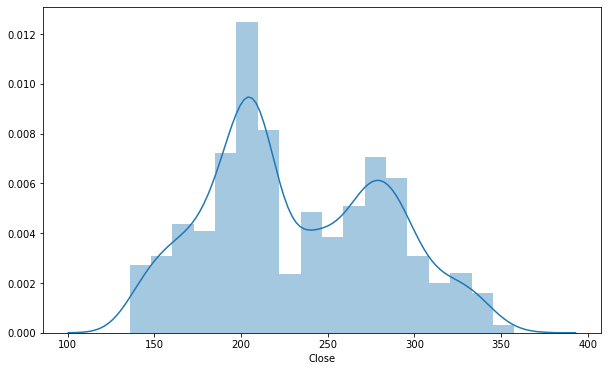

In [519]:
plt.figure(figsize=(10,6))
sns.distplot(df['Close'])

In [520]:
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0      2012-10-09
1      2012-10-10
2      2012-10-11
3      2012-10-12
4      2012-10-15
          ...    
2009   2020-10-05
2010   2020-10-06
2011   2020-10-07
2012   2020-10-08
2013   2020-10-09
Name: Date, Length: 2014, dtype: datetime64[ns]

In [521]:
df['year'] = df['Date'].apply(lambda date: date.year)
df['month'] = df['Date'].apply(lambda date: date.month)
df

,Date,High,Low,Open,Close,Volume,Adj Close,Buy,year,month
0,2012-10-09,145.649994,144.149994,145.529999,144.199997,148872900.0,122.982086,0,2012,10
1,2012-10-10,144.320007,143.089996,144.179993,143.279999,124247500.0,122.197456,0,2012,10
2,2012-10-11,144.490005,143.330002,144.279999,143.360001,123601500.0,122.265709,0,2012,10
3,2012-10-12,143.949997,142.580002,143.460007,142.889999,124181900.0,121.864883,0,2012,10
4,2012-10-15,144.229996,142.770004,143.229996,144.080002,107689100.0,122.879723,1,2012,10
...,...,...,...,...,...,...,...,...,...,...
2009,2020-10-05,339.959991,336.010010,336.059998,339.760010,45713100.0,339.760010,1,2020,10
2010,2020-10-06,342.170013,334.380005,339.910004,334.929993,90128900.0,334.929993,0,2020,10
2011,2020-10-07,341.630005,338.089996,338.119995,340.760010,56999600.0,340.760010,1,2020,10
2012,2020-10-08,343.850006,341.859985,342.850006,343.779999,45242500.0,343.779999,1,2020,10


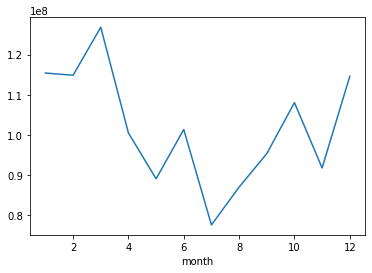

In [522]:
df.groupby('month').mean()['Volume'].plot()

In [523]:
input_vars = ['Open', 'High', 'Low', 'Close', 'Volume', 'month', 'year']

n_tsteps = 15
scaler = StandardScaler()

class Direction:
    UP = 0
    DOWN = 1
    STATIONARY = 2

In [524]:
import math
def prep_data(data, rolling_avg_window_size=5, threshold=0.001):
    df = data[input_vars]
    shift = -(rolling_avg_window_size-1)

    def label_data(row):
        if row['close_avg_change_pct'] > threshold:
            return Direction.UP
        elif row['close_avg_change_pct'] < -threshold:
            return Direction.DOWN
        else:
            return Direction.STATIONARY

    df['close_avg'] = df['Close'].rolling(window=rolling_avg_window_size).mean().shift(shift)
    df['close_avg_change_pct'] = (df['close_avg'] - df['Close']) / df['Close']

    # label data based on direction
    # axis=1 signifies a row-wise operation (axis=0 is col-wise)
    df['movement_labels'] = df.apply(label_data, axis=1)

    data = []
    labels = []

    for i in range(len(df)-n_tsteps+1+shift):
        label = df['movement_labels'].iloc[i+n_tsteps-1]
        if not math.isnan(label):
            data.append(df[input_vars].iloc[i:i+n_tsteps].values)
            labels.append(label)

    data = np.array(data)
    dim1, dim2, dim3 = data.shape
    data = data.reshape(dim1*dim2, dim3)
    data = scaler.fit_transform(data)
    data = data.reshape(dim1, dim2, dim3)

    return data, utils.to_categorical(labels, num_classes=3)

In [525]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Lambda, Flatten, Concatenate
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import utils

def build_TCN():
    inputs = Input(shape=(n_tsteps, len(input_vars)))
    feature_extraction = Conv1D(30, 4, activation='relu')(inputs)
    long_term = Lambda( lambda x: tf.split(x, num_or_size_splits=3, axis=1)[0])(feature_extraction)
    mid_term = Lambda( lambda x: tf.split(x, num_or_size_splits=3, axis=1)[1])(feature_extraction)
    short_term = Lambda( lambda x: tf.split(x, num_or_size_splits=3, axis=1)[2])(feature_extraction)    
    long_term_conv = Conv1D(1, 1, activation='relu')(long_term)
    mid_term_conv = Conv1D(1, 1, activation='relu')(mid_term)
    short_term_conv = Conv1D(1, 1, activation='relu')(short_term)
    combined = Concatenate(axis=1)([long_term_conv, mid_term_conv, short_term_conv])
    flattened = Flatten()(combined)
    # 1 output neuron for each class (Up, Stationary, Down)
    outputs = Dense(3, activation='softmax')(flattened)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss=CategoricalCrossentropy(from_logits=True))
    return model

In [526]:
data1, labels1 = prep_data(df)

<ipython-input-524-3e06b7dbbcb9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close_avg'] = df['Close'].rolling(window=rolling_avg_window_size).mean().shift(shift)
<ipython-input-524-3e06b7dbbcb9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close_avg_change_pct'] = (df['close_avg'] - df['Close']) / df['Close']


In [527]:
model = build_TCN()
model.fit(data1, labels1, validation_split=.3, epochs=20)

Epoch 1/50
44/44 [==============================] - 0s 4ms/step - loss: 1.0846 - val_loss: 1.0710
Epoch 2/50
44/44 [==============================] - 0s 1ms/step - loss: 1.0555 - val_loss: 1.0371
Epoch 3/50
44/44 [==============================] - 0s 1ms/step - loss: 1.0181 - val_loss: 0.9862
Epoch 4/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9980 - val_loss: 0.9761
Epoch 5/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9937 - val_loss: 0.9750
Epoch 6/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9909 - val_loss: 0.9745
Epoch 7/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9883 - val_loss: 0.9746
Epoch 8/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9867 - val_loss: 0.9751
Epoch 9/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9842 - val_loss: 0.9752
Epoch 10/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9816 - val_loss: 0.9760
Epoch 11/50
44/44 [

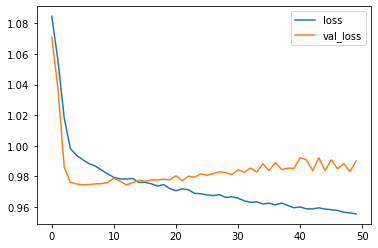

In [528]:
losses = pd.DataFrame(model.history.history)
losses.plot()